# Spectrum ratio


The spectra has been reconstructed by Spectractor.
The Spectra in pickles files


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : June 17th 2022





# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
import pickle

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs/mtab/41g16069m_tmg.fits',
 'comptable': '/sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs/mtab/49i2235im_tmc.fits',
 'thermtable': '/sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [4]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [5]:
from scipy import interpolate

# Functions

In [6]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [7]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [8]:
def GetSpectra(dict_spectra):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    for key, value in dict_spectra.items():
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]
        df["all_fluxes_err"] = value["all_fluxes_err"]
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [9]:
def ConvertToImage(info, all_df,WLMIN=350,WLMAX=1100):
    """
    
    call 
    WL,Mags1,EMags1,AirM,Tim = ConvertToImage(info,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)
    
    
    
    
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))   # table of  magnitudes
    emag_table=np.zeros((N,NWL))  # table of error on magnitudes
    
    
    airm_table=np.zeros(N)
    time_table=np.zeros(N)
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        mag = -2.5*np.log10(df["all_fluxes"])
        errmag = 2.5/np.log(10) * df["all_fluxes_err"]/df["all_fluxes"]
        wavelength = df["all_lambdas"]
        fcn = interpolate.interp1d(wavelength,mag,bounds_error=False,fill_value=(0,0))
        fcn2 = interpolate.interp1d(wavelength,errmag,bounds_error=False,fill_value=(0,0))
            
        mag_table[idx,:] = fcn(WL) 
        emag_table[idx,:] = fcn2(WL) 
        
        airm_table[idx]  = info["airmass"].iloc[idx]
        time_table[idx]  = info["refhour"].iloc[idx]
        
    return WL, mag_table, emag_table,airm_table,time_table
       

In [11]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    for key, value in dict_spectra.items():
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]
            df["all_fluxes_err"] = value["all_fluxes_err"]
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [12]:
def GetBouguerLinesTim(Npoints,wl,tim,magref ,emag,title="log of atmospheric transmission vs time",FLAG_PLOT=True,YMIN=0,YMAX=0):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=tim
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        the_ey=emag[:,iwl]
        the_ey=np.where(the_ey>1,0,the_ey)
        
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
            ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1., ecolor=all_colors[idx], elinewidth = 1.)
    
        
    
    
    if FLAG_PLOT:
        ax.legend(loc='upper right')
        ax.set_xlim(0,the_x.max()*1.2)
        ax.grid()
        ax.set_xlabel("time (Hour)")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title(title)
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
        
     
    return 
     

In [13]:
def GetBouguerLinesAtm(Npoints,wl,airmass,magref ,emag,title="log of atmospheric transmission vs airmass",FLAG_PLOT=True,YMIN=0,YMAX=0):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        the_ey=emag[:,iwl]
        the_ey=np.where(the_ey>1,0,the_ey)
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
            ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1, ecolor=all_colors[idx], elinewidth =1)
    
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
            ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
            ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
    
    
    if FLAG_PLOT:
        ax.legend()
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title(title)
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return wl_sel,Mags,EMags
     

# Constants

# Initialisation

In [14]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [15]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2022-06-18 14:30:44,364 jns-dagoret.cc.in2p3.fr __main__[3149] INFO LA time:05:30:44
2022-06-18 14:30:44,368 jns-dagoret.cc.in2p3.fr __main__[3149] INFO NY time:08:30:44
2022-06-18 14:30:44,371 jns-dagoret.cc.in2p3.fr __main__[3149] INFO London time:13:30:44
2022-06-18 14:30:44,374 jns-dagoret.cc.in2p3.fr __main__[3149] INFO Paris time:14:30:44
2022-06-18 14:30:44,375 jns-dagoret.cc.in2p3.fr __main__[3149] INFO ************************ START *********************


In [16]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [17]:
# config file
# --------------
#configfile = "config/default.ini"
configfile = "config/confprog_run-auxtel-holo-20220317-configFFM.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2022-06-18 14:30:48,161 jns-dagoret.cc.in2p3.fr __main__[3149] INFO Configuration file : config/confprog_run-auxtel-holo-20220317-configFFM.ini


In [18]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2022-06-18 14:30:52,087 jns-dagoret.cc.in2p3.fr __main__[3149] INFO 1) Configuration


In [19]:
config_section = config.sections()

In [20]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [21]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    outputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    outputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [22]:
msg=f" Object observed {target} at {SITE} ({DATE})"
logger.info(msg)

2022-06-18 14:30:54,803 jns-dagoret.cc.in2p3.fr __main__[3149] INFO  Object observed MU col at AUXTEL/Rubin Obs (2022-03-17)


In [23]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [24]:
inputfile

'run-auxtel-holo-20220317-config_DECONVOLUTION_FFM.pickle'

In [25]:
list_of_badnums = [int(nn)  for nn in BADEXPOS.split()]

list_of_badnums

[251, 300, 301, 428, 429]

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [26]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

In [27]:
sed_w=s0.wave/10
sed_f=s0.flux*10*normalisationfactor
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [28]:
sed_m=-2.5*np.log10(sed_f)

## spectrum data

In [29]:
fullfilename=os.path.join(inputdir,inputfile)

In [30]:
with open(fullfilename, 'rb') as f:
    summary_content = pickle.load(f)

In [31]:
NBSPECTRA=len(summary_content)

In [32]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2022-06-18 14:31:07,004 jns-dagoret.cc.in2p3.fr __main__[3149] INFO  Number of selected files is 56


In [33]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [34]:
info, all_spectra  = all_df=GetSpectra(summary_content)

In [35]:
info

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,237,mu. Col,2022-03-18T00:50:48.964,0.000000,1.114453,743.45,8.9,48.0,exposure_2022031700237_postisrccd_spectrum.fits,315.585349,1736.068854,0.192804,180.734482
1,238,mu. Col,2022-03-18T00:51:22.049,0.009190,1.115575,743.45,8.9,48.0,exposure_2022031700238_postisrccd_spectrum.fits,320.561914,1737.931079,0.208636,186.166289
2,244,mu. Col,2022-03-18T00:54:16.312,0.057597,1.121577,743.45,8.9,49.0,exposure_2022031700244_postisrccd_spectrum.fits,308.020361,1732.278663,0.193445,181.171270
3,245,mu. Col,2022-03-18T00:54:49.235,0.066742,1.122727,743.40,8.8,49.0,exposure_2022031700245_postisrccd_spectrum.fits,305.787486,1732.483307,0.191892,180.998286
4,251,mu. Col,2022-03-18T00:57:47.565,0.116278,1.129107,743.40,8.9,50.0,exposure_2022031700251_postisrccd_spectrum.fits,307.486978,1741.027850,0.209163,189.211926
5,252,mu. Col,2022-03-18T00:58:20.709,0.125485,1.130309,743.40,8.9,50.0,exposure_2022031700252_postisrccd_spectrum.fits,308.237192,1740.105221,0.189290,181.103716
6,258,mu. Col,2022-03-18T01:01:18.728,0.174934,1.136923,743.40,8.9,53.0,exposure_2022031700258_postisrccd_spectrum.fits,316.116144,1737.034501,0.192679,181.010609
7,259,mu. Col,2022-03-18T01:01:51.634,0.184075,1.138168,743.30,8.9,52.0,exposure_2022031700259_postisrccd_spectrum.fits,320.120381,1737.680583,0.200832,188.807779
8,266,mu. Col,2022-03-18T01:05:22.622,0.242683,1.146322,743.30,8.9,53.0,exposure_2022031700266_postisrccd_spectrum.fits,305.688549,1741.005802,0.195957,184.174946
9,272,mu. Col,2022-03-18T01:08:18.080,0.291421,1.153339,743.30,8.9,51.0,exposure_2022031700272_postisrccd_spectrum.fits,313.829696,1738.004465,0.197031,180.821888


In [36]:
all_spectra[0].head()

,all_lambdas,all_fluxes,all_fluxes_err,all_lambdas_order2,all_fluxes_order2,all_fluxes_err_order2
0,299.843907,1.294906e-12,1.199674e-14,299.137719,5462.404174,51.594588
1,300.197460,1.196438e-12,1.002146e-14,299.491278,5026.676774,42.898032
2,300.551011,1.052286e-12,7.987621e-15,299.844835,4402.310405,34.047471
3,300.904560,8.634455e-13,6.917208e-15,300.198388,3593.833616,29.438372
4,301.258105,6.621412e-13,6.917912e-15,300.551939,2739.086715,29.427650


In [37]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [38]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-06-18 14:31:13,907 jns-dagoret.cc.in2p3.fr __main__[3149] INFO  Number of good spectra is 56


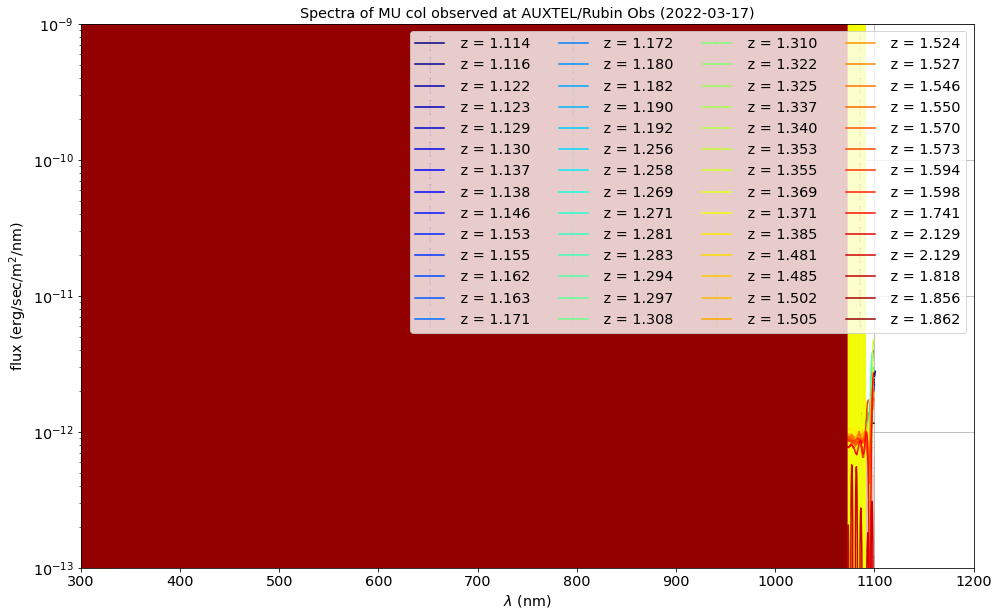

In [39]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    airmassvalue = info.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.3f}"
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df.all_lambdas,the_df.all_fluxes,yerr=the_df.all_fluxes_err, fmt = '-', color=all_colors[ifile],capsize = 0.1, ecolor=all_colors[ifile], elinewidth = .1,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)
ax.set_ylim(1e-13,1e-9)
ax.set_yscale("log")
ax.legend(loc="upper right",ncol=4)

# Convert Not filtered spectra into Mag table

In [40]:
WL,Mags1,EMags1,AirM,Tim = ConvertToImage(info,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)

/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


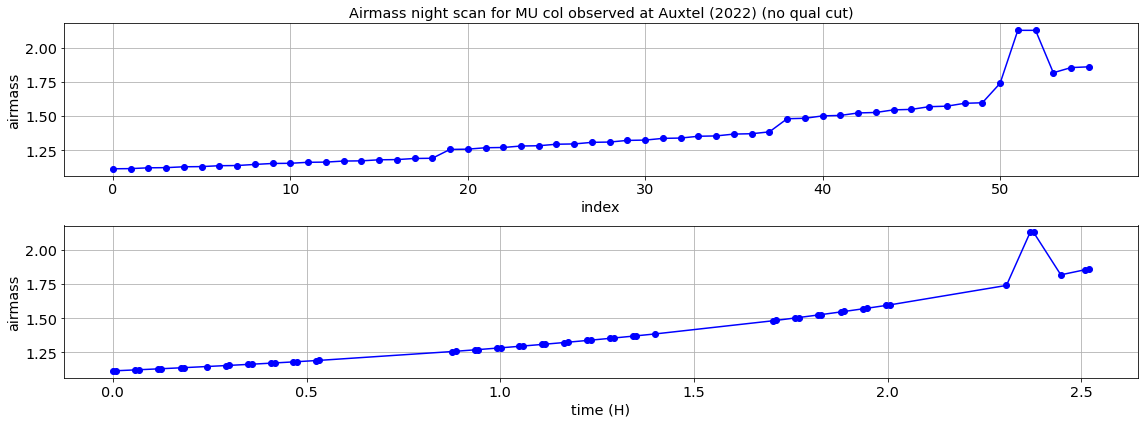

In [41]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at Auxtel (2022) (no qual cut)"
ax1.set_title(title)
ax1.grid()


ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("airmass")
ax2.set_xlabel("time (H)")
ax2.grid()

plt.tight_layout()


# Remove bad  spectra

In [43]:
selection_cut = ((info.d2ccd > 180) & (info.d2ccd < 182)) & (info.object == "mu. Col")
bad_cut = ~selection_cut

In [44]:
list_of_badnums = info[bad_cut]["number"].values

In [45]:
infos, all_spectra =  GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums)

Remove spectrum 1 for exposure 238
Remove spectrum 4 for exposure 251
Remove spectrum 7 for exposure 259
Remove spectrum 8 for exposure 266
Remove spectrum 15 for exposure 293
Remove spectrum 16 for exposure 294
Remove spectrum 22 for exposure 317
Remove spectrum 27 for exposure 337
Remove spectrum 28 for exposure 338
Remove spectrum 29 for exposure 344
Remove spectrum 34 for exposure 359
Remove spectrum 36 for exposure 366
Remove spectrum 48 for exposure 414
Remove spectrum 49 for exposure 415
Remove spectrum 51 for exposure 428
Remove spectrum 52 for exposure 429
Remove spectrum 53 for exposure 436
Remove spectrum 54 for exposure 442
Remove spectrum 55 for exposure 443


In [46]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,237,mu. Col,2022-03-18T00:50:48.964,0.000000,1.114453,743.45,8.9,48.0,exposure_2022031700237_postisrccd_spectrum.fits,315.585349,1736.068854,0.192804,180.734482
2,244,mu. Col,2022-03-18T00:54:16.312,0.057597,1.121577,743.45,8.9,49.0,exposure_2022031700244_postisrccd_spectrum.fits,308.020361,1732.278663,0.193445,181.171270
3,245,mu. Col,2022-03-18T00:54:49.235,0.066742,1.122727,743.40,8.8,49.0,exposure_2022031700245_postisrccd_spectrum.fits,305.787486,1732.483307,0.191892,180.998286
5,252,mu. Col,2022-03-18T00:58:20.709,0.125485,1.130309,743.40,8.9,50.0,exposure_2022031700252_postisrccd_spectrum.fits,308.237192,1740.105221,0.189290,181.103716
6,258,mu. Col,2022-03-18T01:01:18.728,0.174934,1.136923,743.40,8.9,53.0,exposure_2022031700258_postisrccd_spectrum.fits,316.116144,1737.034501,0.192679,181.010609
9,272,mu. Col,2022-03-18T01:08:18.080,0.291421,1.153339,743.30,8.9,51.0,exposure_2022031700272_postisrccd_spectrum.fits,313.829696,1738.004465,0.197031,180.821888
10,273,mu. Col,2022-03-18T01:08:50.992,0.300563,1.154683,743.35,8.9,51.0,exposure_2022031700273_postisrccd_spectrum.fits,311.561151,1739.437465,0.189327,181.120576
11,279,mu. Col,2022-03-18T01:11:46.031,0.349185,1.161939,743.40,8.9,53.0,exposure_2022031700279_postisrccd_spectrum.fits,308.000273,1739.511651,0.190627,181.068891
12,280,mu. Col,2022-03-18T01:12:18.936,0.358326,1.163327,743.40,8.9,53.0,exposure_2022031700280_postisrccd_spectrum.fits,306.876884,1741.352349,0.186678,181.094828
13,286,mu. Col,2022-03-18T01:15:18.583,0.408228,1.171053,743.45,8.9,54.0,exposure_2022031700286_postisrccd_spectrum.fits,303.959275,1742.577882,0.182337,180.988135


# Convert Not filtered spectra into Mag table

In [47]:
NBSPECTRA=len(all_spectra)

In [48]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [49]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-06-18 14:33:37,987 jns-dagoret.cc.in2p3.fr __main__[3149] INFO  Number of good spectra is 37


In [50]:
indexref = 0
ref_spectrum = all_spectra[indexref]
x0 =  ref_spectrum["all_lambdas"]
y0 =  ref_spectrum["all_fluxes"]
flux0 = np.interp(WL, x0, y0, left=None, right=None, period=None)

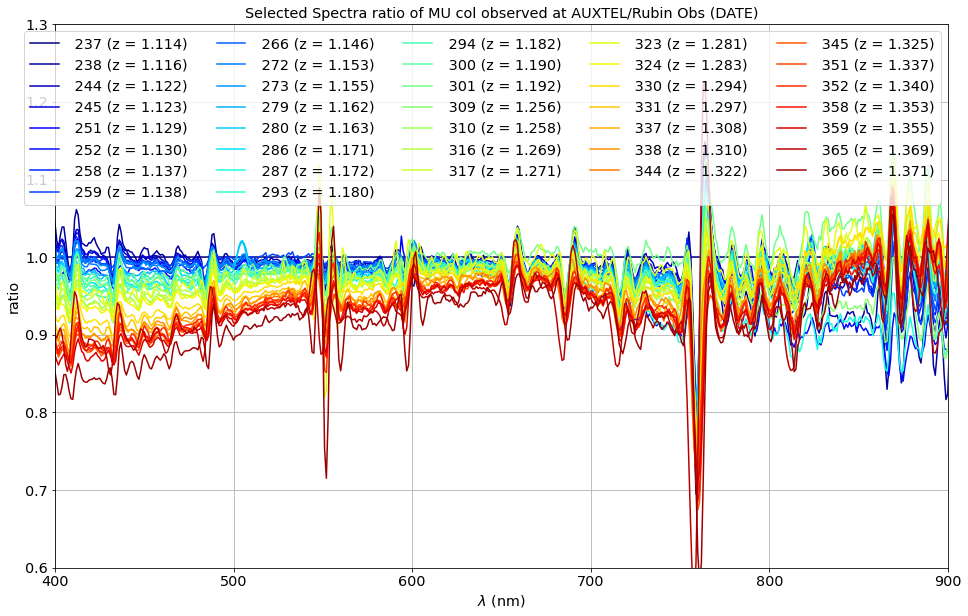

In [51]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    numbervalue = info.iloc[ifile]["number"]
    airmassvalue = info.iloc[ifile]["airmass"]
    label_number_airmass = f" {numbervalue} (z = {airmassvalue:.3f})"

    x =  the_df["all_lambdas"]
    y =  the_df["all_fluxes"]
    flux = np.interp(WL, x, y, left=None, right=None, period=None)
    ratio = flux/flux0
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.plot(WL,ratio,color=all_colors[ifile],label= label_number_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")
title=f"Selected Spectra ratio of {target} observed at {SITE} (DATE)"
ax.set_title(title)
#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(400,900)
ax.set_ylim(0.6,1.3)
plt.legend(loc="upper right", ncol=5)
#ax.set_yscale("log")

In [52]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)


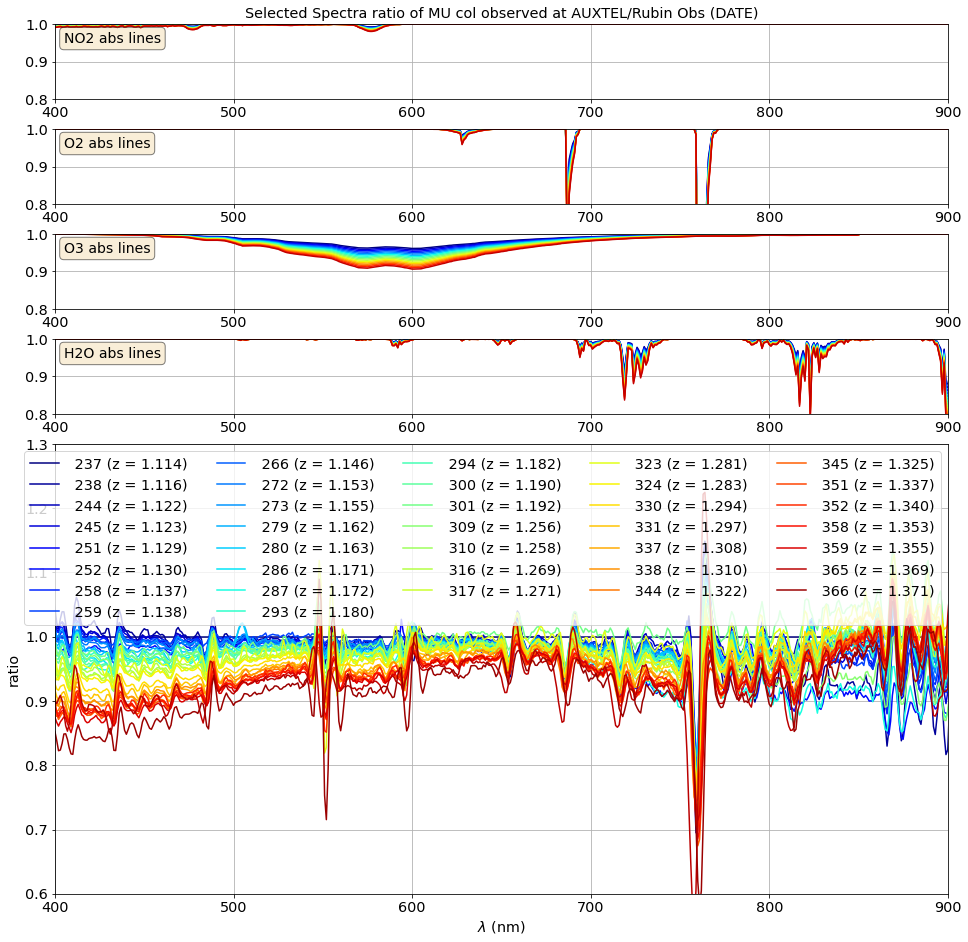

In [53]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title=f"Selected Spectra ratio of {target} observed at {SITE} (DATE)"


gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,3] ,figure=fig)

# NO2    
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "NO2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_title(title)
main_ax = ax



# O2    
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)


# Ozone
ax=fig.add_subplot(gs[2,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# H2O
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# spectrum ratio

ax=fig.add_subplot(gs[4,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)



for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    numbervalue = info.iloc[ifile]["number"]
    airmassvalue = info.iloc[ifile]["airmass"]
    label_number_airmass = f" {numbervalue} (z = {airmassvalue:.3f})"

    x =  the_df["all_lambdas"]
    y =  the_df["all_fluxes"]
    flux = np.interp(WL, x, y, left=None, right=None, period=None)
    ratio = flux/flux0
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.plot(WL,ratio,color=all_colors[ifile],label= label_number_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("ratio")


#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(400,900)
ax.set_ylim(0.6,1.3)
plt.legend(loc="upper right", ncol=5)
